In [2]:
import pandas as pd
import numpy as np

# Python Project
The goal of the project is to study a dataset and apply learning methods on it, using Python and packages such as sklearn, pandas and numpy.
In our case, we will study the [YearPredictionMSD Data Set](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). The elements of the dataset are 515345 songs, with 90 attributes representing timbre variances and covariances, and the target is the release year of the song. We will call all the variances and covariances of the timbres 'timbre or feature [1 to 90]' from now on.

The dataset contains mostly western and pop music, and the audio features are described as real numbers.
We will try modelling a regression for estimating the release year of a song. We might also try another approach using ranges of years (70s, 80s... for example) if the results are not satisfying.

## Data Visualization
First, we will use pandas in order to visualize our dataset within a dataframe

In [3]:
df = pd.read_csv("data/YearPredictionMSD.txt", sep = ",", header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Here we see the first column represents our target, which are the release dates of the songs, and the 90 others are the features.
Let's then store the target in a pandas `Series`

In [163]:
df.isnull().values.any()

False

We also verify that there are no missing values ! Handy.

In [3]:
target = df.iloc[0:,0]

0         2001
1         2001
2         2001
3         2001
4         2001
          ... 
515340    2006
515341    2006
515342    2006
515343    2006
515344    2005
Name: 0, Length: 515345, dtype: int64

### Is the data evenly spread ?
To have a better intuition on how the dataset looks like, we may want to know how the release years are distributed, for that we will use a simple graph using the number of occurences of each release year. In the dataset information, we can only read that there is a peak in the 2000s, let's verify that. First let's import `matplotlib` :

In [2]:
import matplotlib.pyplot as plt

Then compute the sums of each years occurences to create the two input lists in our `plot`

In [12]:
x = [i for i in range(1922,2012)] # the dataset information says that the years ranges from 1922 to 2011
y = [0] * len(x)
for year in target:
    y[year-1922] += 1

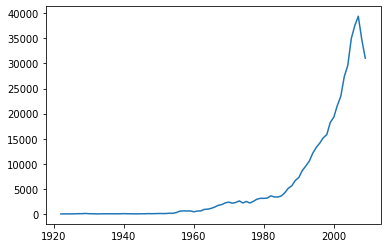

In [15]:
plt.plot(x[0:-2],y[0:-2])

We see that the data is **unevenly spreaded**, if we look at the number of occurences of a year in the dataset, relative to the year, the obtained graph seems to represent an **exponential** growth. We thought about pre-processing methods in order to solve this problem, for example, we could duplicate values in the 1920 to 1980 range or ignore most values in the 1980-2010 range to obtain a more evenly distributed dataset.

The problem with duplicating will be the _computational time_ (5 million entries may be way too long to process for our little computers) and ignoring data could lead to _poor results_ if there is not enough correlation between the features and the target... 

According to _Pre-processing Protocol for Nonlinear Regression of Uneven Spaced-Data_ from P. Panja et al. 2020, it could be possible to use only 5-10% of the data and still get good results if the right method is used, however we are not sure that the methods presented are applicable in our case.

We could do both to mitigate the drowbacks from each method, by **duplicating** some values and **ignoring** others.

We also need to consider how we will **evaluate** our model : a naïve model assigning a release year around 2000 to any song could have good MAE, even if for old songs it predicts very badly. We thought about attributing more weight to a specific error according to the frequency of the corresponding release year in the dataset. However the effect could become the opposite, and the model start to badly predict a lot of modern songs since they would not matter as much. 

So another important question to ask ourselves is, _what model are we trying to achieve, and what do we consider good or bad ?_

One lead we decided to follow is to try minimizing the RMSE, but also the difference between RMSE and MAE. Because the MAE does not account for big errors unlike the RMSE, we could for example try minimizing $(RMSE - MAE) * RMSE$

### Distribution of the features

To know how the features are distributed, we will try plotting simple histograms and also try using _kernel density estimation_ using `pandas`

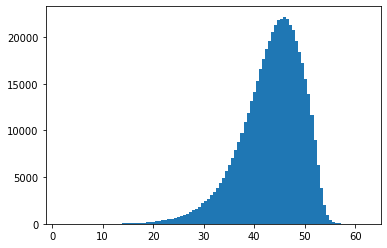

In [62]:
 fig1 = plt.hist(df.iloc[:,1], bins = 100)

<AxesSubplot:ylabel='Density'>

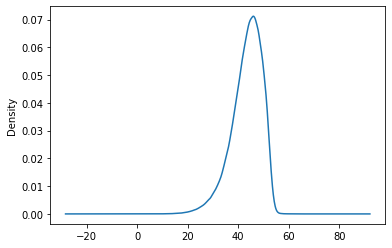

In [61]:
df.iloc[:,1].plot.kde()

After this first try with the first predictor, we obtain a smooth distribution looking like a $\chi^2$ distribution. The KDE takes quite a time so we will create only histograms for all predictors, and store them in a **figures directory** as there are 90 of them.

```python
for i in range(1, 91):
    fig = plt.figure(i)
    plt.hist(df.iloc[:,i], bins = 100)
    plt.title("Histogram of timbre " + str(i))
    fig.savefig("figures/fig" + str(i) + ".png")
    
```

By looking at the figures, we see that overall, the distributions are mostly normal, and some are $\chi^2$-like

We also see that in most graphs, there are outliers very far away from the rest of the entries, in very few numbers (it can be 1 or 2), we decide not to pay too much attention to them.

**EDIT :** After re-reading the description of the dataset, we thought something was a little bit unclear, what do the variables REALLY represent ? We knew they represented timbres **variances** and **covariances**, but the number of timbres was unclear. Since the dataset is not annoted we just told ourselves that this was just not really interpretable by humans, after all we dont know about a timbre, how it was computed, nor in which order they were put into the dataset (because there is not much information). But hey, if we have _12 variances_, we should have _66 covariances_ : because $C^{2}_{12} = 66$.

But the dataset description mentions _78 covariances_ and _12 variances_. What we actually think is that the first 12 features represent the timbres ! Or maybe their mean value or something related. That would make sense because when we look at the distribution of the variables, We can cluster them into the first 12, the next 12, and the 66 remainings. The remaining 66 should represent covariances, because they have the same normal distribution, with big outliers, and can take on values ranging from -10000 to 10000 approximately. The features 13 to 24 should represent variances, because they only have positive values and kind of a $\chi^2$ distribution. The first 12 features can then only represent the timbres themselves.

That would mean we actually have 12 timbres values (probably the mean over the song), with their variance and covariances.

### Normalizing the data

Since the features are not readable for us (they represent timbres, so their actual value does not mean a lot for us humans) we should normalize them in order to avoid any issue with the models we will use. However we would like to keep the target as it is.

In [4]:
df.iloc[:,1:] = (df.iloc[:,1:]-df.iloc[:,1:].mean())/df.iloc[:,1:].std()

### Pairwise comparison

We would like to compare features pairwise in order to know if we could make efficient transformations on them, for future model fitting

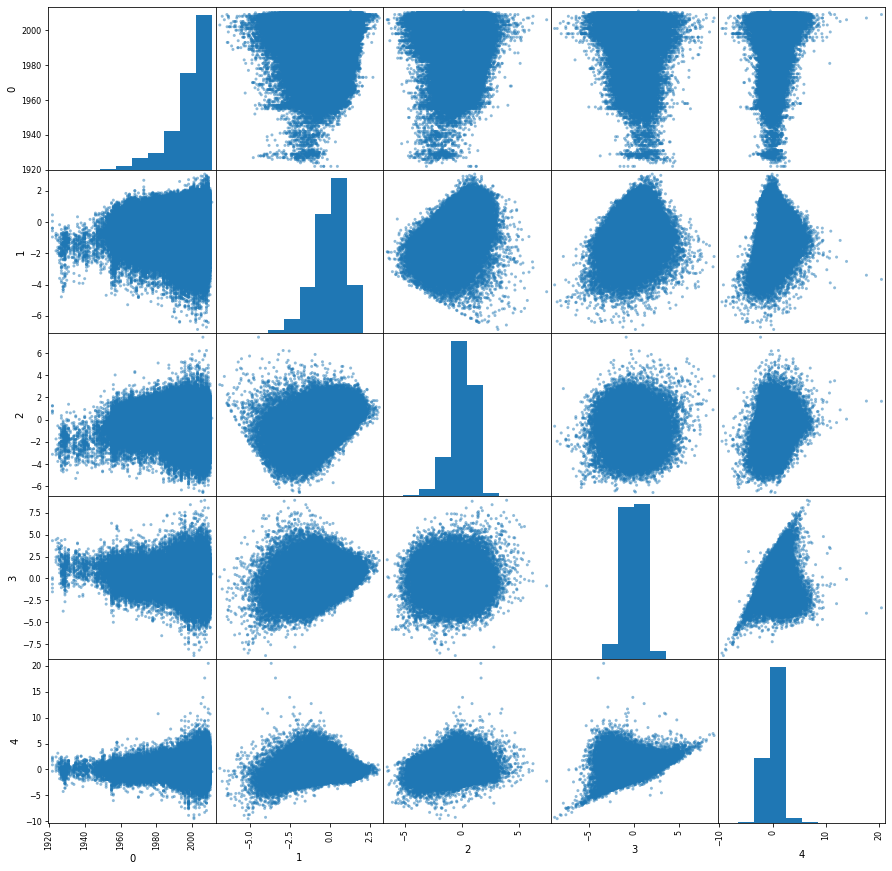

In [161]:
infos = pd.plotting.scatter_matrix(df.iloc[:,:5], figsize=(15,15))

It takes some time to compute a comparison between all features (would take hours in our case) but we can already make some assumptions from the above. When we compare the target to the features, we see the data becomes more and more _spread_ when the year increases : this can be explained by the distribution of the target as seen previously. There are no indications (at least from the above) that it is useful make any transformation to better suit the target (no logarithmic or exponential shape etc) we still could try computing the relationship between the target and all features just to be sure.

Between all other features, nothing interesting comes up, except maybe between feature  3 and 4, it seems that the cloud of points is cut, the points are not able to pass a certain line in the graph, we should check their correlation later. (turns out 1 and 2 are actually more correlated than 3 and 4) 

**Conclusion :** That does not help much, the timbres seem almost random, and we cannot think about any useful transformation

### Correlation between predictors and target

We would like to know more about the correlation between our variables, in order to have ideas for models we could use. We could expect correlation between some variables, which could lead us to perform a PCA to simplify our models for example.

For that we will use the pandas `corr` method from `DataFrame` objects.

We also have seen that the distribution of the target is not **normal**, hence we will not use the Pearson correlation test. There is a lot of tied data, which also excludes the Spearman method. We will then use the Kendall correlation test. (What interests us the most is the correlation with the target)

In [17]:
corr_mat_kendall = df.corr(method = "kendall")

%store corr_mat_kendall

Stored 'corr_mat_kendall' (DataFrame)


In [17]:
%store -r corr_mat_kendall
corr_mat_kendall

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,1.000000,0.174330,-0.019352,-0.076255,-0.029807,0.014749,-0.115107,0.075457,-0.020832,-0.017835,...,-0.040912,0.011267,0.033903,0.026939,0.044010,-0.055927,0.025416,-0.058600,0.003181,-0.048850
1,0.174330,1.000000,0.384871,0.193968,-0.018880,-0.178695,-0.246671,0.108560,0.028148,0.102088,...,-0.251143,0.149745,-0.079823,0.018768,0.062632,-0.064560,0.030620,-0.098068,-0.081011,-0.105163
2,-0.019352,0.384871,1.000000,0.025763,0.073195,-0.113737,-0.122303,0.077303,0.147265,0.046233,...,-0.188996,0.064553,-0.117597,0.017433,0.072808,0.015693,0.008652,-0.002286,-0.064790,-0.095159
3,-0.076255,0.193968,0.025763,1.000000,0.164522,-0.117746,-0.020643,-0.020518,0.066974,0.041280,...,0.022503,0.102148,0.083117,-0.005278,-0.034403,-0.088595,0.069080,-0.037873,-0.074775,0.057395
4,-0.029807,-0.018880,0.073195,0.164522,1.000000,0.030491,0.209112,0.204218,0.033995,-0.029740,...,0.004706,-0.011805,-0.015862,0.041609,-0.059172,0.046949,0.039149,0.157812,0.031478,0.012913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,-0.055927,-0.064560,0.015693,-0.088595,0.046949,0.028955,0.184581,-0.015260,-0.028008,-0.002353,...,0.004576,-0.106846,0.023419,0.052367,0.036986,1.000000,-0.023139,0.161394,0.109352,-0.002579
87,0.025416,0.030620,0.008652,0.069080,0.039149,0.009655,-0.042000,0.011182,0.016907,0.049293,...,0.034958,-0.000848,0.097913,0.171795,0.005915,-0.023139,1.000000,0.012080,0.025438,0.223375
88,-0.058600,-0.098068,-0.002286,-0.037873,0.157812,-0.016774,0.096425,0.047648,0.033667,-0.003034,...,0.042156,0.039622,0.156291,0.001356,-0.136939,0.161394,0.012080,1.000000,0.059975,0.139760
89,0.003181,-0.081011,-0.064790,-0.074775,0.031478,0.012474,0.006116,0.055652,-0.003988,-0.020032,...,0.069375,-0.039968,0.022140,-0.016809,-0.022787,0.109352,0.025438,0.059975,1.000000,0.160192


In [24]:
for i in range(1, len(corr_mat_kendall.iloc[0])): # starting from 1 because we do not care about the correlation with itself
    if abs(corr_mat_kendall.iloc[0,i]) > 0.1:
        print(corr_mat_kendall.iloc[0,i], i)

0.17433005526633033 1
-0.11510658521495813 6
-0.1111940005374848 63


For most variables, the correlation is very **low** ($< 0.1$) however we see some values over 0.2 which can be interesting, and also we are directly interested in the highest correlations between the target and the features as we would like to fit a first linear regression model.

There are 3 features which have a correlation with the target higher than 0.1 : feature 1, 6 and 63.

We could try starting with these 3 features, to fit a _multiple linear regression model_.
For that, we should check if the features have a high correlation between each other, which if it does would have a negative impact on the model (fitting a model with 2 highly correlated predictors is not efficient).

In [72]:
potential_preds = [1,6,63]
for pred1 in potential_preds:
    for pred2 in potential_preds:
        if pred1 < pred2:
            print("Timbre " + str(pred1) + " and timbre " + str(pred2) + " have a correlation of " + str(corr_mat_kendall.iloc[pred1,pred2]))

Timbre 1 and timbre 6 have a correlation of -0.24667149279989994
Timbre 1 and timbre 63 have a correlation of -0.3587919363609903
Timbre 6 and timbre 63 have a correlation of 0.1106490027746619


Unfortunately the predictors have a high correlation between each other (compared to the overall correlation matrix, $> 0.1$) however we will still try it.

Another method we are thinking of for fitting the multiple linear regression with the right predictors, is by adding one by one the predictors minimizing the RSS (or another criteria we will choose) up to a certain amount of predictors (_forward selection_). This would be greedy but offer the best results (and still be faster than a _backwards selection_). To choose how many predictors we will have, we can compare the RSS for each step in a plot and try finding an elbow, or stop before if the computation time is too long.

### Splitting the dataset

The recommendations for splitting the dataset into training and testing sets is the following : 
- _train_: first 463,715 examples
- _test_: last 51,630 examples

These exclude any $k$-fold cross-validation test because it would create a _producer effect_ (when songs from the same artist are in both training and testing sets)



(The splitting ratio is roughly a 80/20. We may want to optimize the hyperparameters after the training using the testing set, in order not to compromise the model and avoid _data leakeage_, we would split the testing test in half : resulting in a _testing_ set and a _validation_ set. For that we should check the distribution)

In [5]:
train = df.iloc[:463715]
test = df.iloc[463715:]
#test = df.iloc[463715:489715]
#validation = df.iloc[489715:]

## PCA

We would like to have a dataset containing less features, to train faster and see if we can still obtain interesting models, this will not replace our original dataset but complement it. Of course the new dataset will not explain all the variance because there is not much correlation between features (we did not do any test such as Bartlett or KMO to see the relevance of the PCA), but it is worth the try.

In [165]:
from sklearn.decomposition import PCA

In [172]:
pca_5ft = PCA(n_components=5)
pca_10ft = PCA(n_components=10) 

pca_5ft.fit(df.iloc[:,1:])
pca_10ft.fit(df.iloc[:,1:])

PCA(n_components=10)

In [174]:
pca_data_5ft = pd.DataFrame(pca_5ft.transform(df.iloc[:,1:]))
pca_data_10ft = pd.DataFrame(pca_10ft.transform(df.iloc[:,1:]))

%store pca_data_5ft
%store pca_data_10ft

Stored 'pca_data_5ft' (DataFrame)
Stored 'pca_data_10ft' (DataFrame)


In [178]:
%store -r pca_data_5ft
%store -r pca_data_10ft

In [191]:
train_pca_5ft = pca_data_5ft.iloc[:463715]
test_pca_5ft = pca_data_5ft.iloc[463715:]
train_pca_10ft = pca_data_10ft.iloc[:463715]
test_pca_10ft = pca_data_10ft.iloc[463715:]

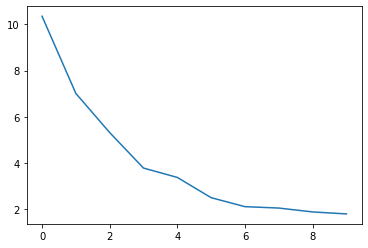

In [220]:
pca_5ft.explained_variance_
pca_10ft.explained_variance_
#plt.plot(pca_10ft.explained_variance_)

We now have 2 more datasets with 5 and 10 features respectively

**Important to remember :** These training and testing set do not include the target, it has to be used from the original train and test sets.

## Linear Regression

Let's try fitting our first models using linear regression

### First simple model

In [6]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    r2_adj = 1-((1-r2)* (len(y_true)-1)/(len(y_true)-91))
    custom_metric = (np.sqrt(mse)-mean_absolute_error)*np.sqrt(mse)

    print('explained_variance: ', round(explained_variance,4))    
    print('R^2: ', round(r2,4))
    print('R^2adj: ', round(r2_adj,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('(RMSE-MAE)*RMSE:',round(custom_metric, 4))

In [84]:
from sklearn import linear_model

In [130]:
lm1 = linear_model.LinearRegression()
lm1.fit(train.iloc[:,[1,6,63]], train.iloc[:,0])

y_pred = lm1.predict(test.iloc[:,[1,6,63]])

regression_results(test.iloc[:,0], y_pred)

explained_variance:  0.0574
r2:  0.0572
MAE:  7.8373
MSE:  111.0295
RMSE:  10.5371


As expected, the model performs pretty poorly, judging the MAE, our model will most of the time make a prediction wrong by almost 8 years... the RMSE is even higher at 10.5 which can warn us that some values are very badly predicted

In [177]:
lm1_results = pd.DataFrame({'Real Value': test.iloc[:,0], 'Predicted Value': y_pred})

#for i in range(len(lm1_results.iloc[:,0])):
#    if lm1_results.iloc[i,0] < 1960:
#        print(abs(lm1_results.iloc[i,0] - lm1_results.iloc[i,1]))
        
np.mean([abs(lm1_results.iloc[i,0] - lm1_results.iloc[i,1]) for i in range(len(lm1_results.iloc[:,0])) if lm1_results.iloc[i,0] < 1960])

42.98441843382478

We printed the absolute errors of the songs with a release year before 1960, and the results are pretty clear : our model tends to predict years close to 2000, so the errors are pretty big. The MAE in this case is almost 43 ! There is no song correctly predicted in this interval.

We can understand better now that our model has such a low $R^2$, it is not that far from the most naïve model...

Let's now try using the features from our PCA !

### Second MLR using PCA

In [200]:
lm_pca_5ft = linear_model.LinearRegression()
lm_pca_5ft.fit(train_pca_5ft, train.iloc[:,0])

print("lm_pca_5ft")
regression_results(test.iloc[:,0], lm_pca_5ft.predict(test_pca_5ft))

lm_pca_10ft = linear_model.LinearRegression()
lm_pca_10ft.fit(train_pca_10ft, train.iloc[:,0])

print("\nlm_pca_10ft")
regression_results(test.iloc[:,0], lm_pca_10ft.predict(test_pca_10ft))

lm_pca_5ft
explained_variance:  0.0355
r2:  0.0355
MAE:  7.9494
MSE:  113.5853
RMSE:  10.6576

lm_pca_10ft
explained_variance:  0.0632
r2:  0.0632
MAE:  7.8041
MSE:  110.3183
RMSE:  10.5033


Let's save our models in a `models` directory using `joblib` :

In [204]:
from joblib import dump, load

dump(lm1, 'models/lm1.joblib')
dump(lm_pca_5ft, 'models/lm_pca_5ft.joblib')
dump(lm_pca_10ft, 'models/lm_pca_10ft.joblib')

['models/lm_pca_10ft.joblib']

In [205]:
#lm_pca_10ft = load("models/lm_pca_10ft.joblib")

### One last MLR model

We were not sure about using any cross validation method because the description provided with the dataset warns about a 'producer effect' which would create a wrong model, however our models are already wrong (using linear regression at least), so why not give it a last try, by adding features using _forward selection_ ?

In [217]:
from sklearn.feature_selection import SelectKBest, f_regression

X = train.iloc[:,1:]
y = train.iloc[:,0]

X_new = SelectKBest(f_regression, k=20).fit_transform(X, y)
test_new = SelectKBest(f_regression, k=20).fit_transform(test.iloc[:,1:], test.iloc[:,0])

lm_20best = linear_model.LinearRegression().fit(X_new, y)
regression_results(test.iloc[:,0], lm_20best.predict(test_new))

explained_variance:  0.1065
r2:  0.1064
MAE:  7.6221
MSE:  105.2306
RMSE:  10.2582


### Or two...

In [214]:
lm_all = linear_model.LinearRegression().fit(X, y)

regression_results(test.iloc[:,0], lm_all.predict(test.iloc[:,1:]))

explained_variance:  0.232
r2:  0.232
MAE:  6.8005
MSE:  90.4432
RMSE:  9.5102


In [218]:
dump(lm_20best, 'models/lm_20best.joblib')
dump(lm_all, 'models/lm_all.joblib')

['models/lm_all.joblib']

We finally also fitted a model with all the features, which has a lower error and higher $R^2$ than all our previous models, however it is still very weak and we have no way to improve this kind of model further.

We could have anticipated that, because of how our data is uncorrelated, of course a linear regression approach would not have been sufficient. Our guesses here are that the best way to obtain good results at this point is by using a neural network (but it's less fun if we don't try anything else before !). We will then try using `keras` to implement a neuron network.

## Go Deep Learning !

Just for more readability between the datasets, we will create new variables (since the previous code already works we will not be modifying it) :

In [7]:
X_train = train.iloc[:,1:].to_numpy() # features of the training set
X_test = test.iloc[:,1:].to_numpy() # features of the testing set
y_train = train.iloc[:,0].to_numpy() # target of the training set
y_test = test.iloc[:,0].to_numpy() # target of the testing set

In [8]:
y_train_norm = (y_train - 1922) / (2011 - 1922)
y_test_norm = (y_test - 1922) / (2011 - 1922)

We searched for advice in order to know how to implement our deep learning model, because it is hard to estimate how many neurons and hidden layers we should use. We stumbled upon interesting guidelines :

**Number of layers :**
- 0 layer if the problem is linear (linear regression)
- 1 layer to approximate any function with a continuous mapping from one finite space to another
- 2 layers to represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions or approximate any smooth mapping to any accuracy

**Number of neurons :**
- Keep the number of neurons as low as possible
- The number of neurons should be between the input and output size
- The number of neurons should be 2/3 the size of the input + the size of the output
- The number of neurons should not be more than twice the size of the input

In our case, we have 90 features, and our output is continuous. However we could also choose to represent our output with 89 neurons, representing the years between 1922 and 2011 : this way we could compute the probabilities of belonging in a year or not.

So, according to the guidelines, we should use around 60 neurons, displayed on 2 layers (because the function we seek is very complex and definitely not linear)

In [9]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras import optimizers
import tensorflow as tf

In [17]:
model = Sequential()
model.add(Dense(30, input_shape=(90,), activation='relu'))
model.add(Dense(30, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(1, ))
model.compile(loss="mean_squared_error", optimizer = optimizers.SGD(lr=0.05))

Let's now fit the model :

In [18]:
history = model.fit(X_train, y_train_norm, epochs = 100)

Epoch 1/100
14492/14492 [==============================] - 21s 1ms/step - loss: 0.0168
Epoch 2/100
14492/14492 [==============================] - 20s 1ms/step - loss: 0.0112
Epoch 3/100
14492/14492 [==============================] - 21s 1ms/step - loss: 0.0106
Epoch 4/100
14492/14492 [==============================] - 23s 2ms/step - loss: 0.0105
Epoch 5/100
14492/14492 [==============================] - 21s 1ms/step - loss: 0.0104
Epoch 6/100
14492/14492 [==============================] - 20s 1ms/step - loss: 0.0102
Epoch 7/100
14492/14492 [==============================] - 21s 1ms/step - loss: 0.0101
Epoch 8/100
14492/14492 [==============================] - 22s 1ms/step - loss: 0.0101
Epoch 9/100
14492/14492 [==============================] - 21s 1ms/step - loss: 0.0101
Epoch 10/100
14492/14492 [==============================] - 21s 1ms/step - loss: 0.0100
Epoch 11/100
14492/14492 [==============================] - 21s 1ms/step - loss: 0.0100
Epoch 12/100
14492/14492 [===============

14492/14492 [==============================] - 20s 1ms/step - loss: 0.0092
Epoch 95/100
14492/14492 [==============================] - 20s 1ms/step - loss: 0.0092
Epoch 96/100
14492/14492 [==============================] - 21s 1ms/step - loss: 0.0091
Epoch 97/100
14492/14492 [==============================] - 22s 1ms/step - loss: 0.0091
Epoch 98/100
14492/14492 [==============================] - 22s 1ms/step - loss: 0.0092
Epoch 99/100
14492/14492 [==============================] - 22s 2ms/step - loss: 0.0092
Epoch 100/100
14492/14492 [==============================] - 21s 1ms/step - loss: 0.0092


And we would also like to save it, `joblib` does not work for this kind of model, so we will use the built-in save method from `keras`, this one however will save the model into a directory, so we should first create one using `os`

In [23]:
import os

In [24]:
os.mkdir("models/model1_sgd_epochs100")
model.save('models/model1_sgd_epochs100')

INFO:tensorflow:Assets written to: models/model1_sgd_epochs100\assets


In [25]:
model_test_load = load_model('models/model1_sgd_epochs100')

In [26]:
y_test_pred = model_test_load.predict(X_test)

In [28]:
regression_results(y_test,y_test_pred* (2011-1922) + 1922)
print(np.mean([abs(y_test_pred[i] * (2011-1922) + 1922 - y_test[i]) for i in range(len(y_test)) if y_test[i] < 1960]))
print(np.mean([abs(int(y_test_pred[i] * (2011-1922) + 1922) - y_test[i]) for i in range(len(y_test)) if y_test[i] < 1960]))

explained_variance:  0.3316
R^2:  0.3302
R^2adj:  0.329
MAE:  6.1495
MSE:  78.8799
RMSE:  8.8814
(RMSE-MAE)*RMSE: 24.2636
37.063324
36.55555555555556


### Model 2 and tuner

We approximately know how many neurons and layers we should choose, however we still need to try a bunch of combinations. Like we would do a grid search with cross validation on a more classic ML model, we would like to tune the hyperparameters of our model. For that we will use the `kerastuner` package.

The computation takes a long time, so we trained and tuned the models separately, which is why not all results are always displayed. However the code for it is still there.

In [35]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time

#### Tuner

In [38]:
def Build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int("input_units",20,60,10), input_shape=X_train.shape[1:], activation= 'relu'))
    
    for i in range(hp.Int("n_layers",1,3)):
        model.add(Dense(hp.Int("units" + str(i),20,60,10), activation= "relu"))
        
    model.add(Dense(1, activation="linear"))
    
    model.compile(loss='mean_squared_error', 
                  optimizer = optimizers.Adam(hp.Choice('learning_rate',[1e-1,1e-2,1e-3])),
                  metrics=["mean_squared_error"])
    return model

In [39]:
LOG_DIR = f"models/{int(time.time())}"

tuner = RandomSearch(
        Build_model,
        objective = "val_mean_squared_error",
        max_trials = 20,
        executions_per_trial = 2,
        directory = LOG_DIR)

tuner.search(x= X_train,
            y= y_train_norm,
            epochs=10,
            validation_data=(X_test,y_test_norm))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
input_units       |40                |?                 
n_layers          |1                 |?                 
units0            |30                |?                 
learning_rate     |0.001             |?                 

Epoch 1/10
14492/14492 [==============================] - 27s 2ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 2/10
14492/14492 [==============================] - 26s 2ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 3/10
14492/14492 [==============================] - 25s 2ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 4/10
 6263/14492 [===========>..................] - ETA: 13s - loss: 0.0096 - mean_squared_error: 0.0096

KeyboardInterrupt: 

In [ ]:
tuner.results_summary()

#### Model 2

After the first tuning (which we did using the adam optimizer instead of the stochastic gradient descent) we obtained the following hyperparameters :
```py
input_units: 50
n_layers: 2
units0: 30
learning_rate: 0.001
units1: 20
```
So let's train the corresponding model with more epochs (in the last one, 100 seemed more than necessary)

In [30]:
model2 = Sequential()
model2.add(Dense(50, input_shape=X_train.shape[1:], activation='relu'))
model2.add(Dense(30, activation='relu'))
model2.add(Dense(20, activation='relu'))
model2.add(Dense(1, activation='linear'))
model2.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['mean_squared_error'])

In [32]:
history2 = model2.fit(X_train, y_train_norm, epochs = 30, validation_data= (X_test, y_test_norm))

Epoch 1/30
14492/14492 [==============================] - 28s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 2/30
14492/14492 [==============================] - 26s 2ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 3/30
14492/14492 [==============================] - 27s 2ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 4/30
14492/14492 [==============================] - 30s 2ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 5/30
14492/14492 [==============================] - 27s 2ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 6/30
14492/14492 [==============================] - 27s 2ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0099 - val_mean_squared_error: 0.009

In [40]:
y_test_pred2 = model2.predict(X_test)

In [41]:
regression_results(y_test,y_test_pred2 * (2011-1922) + 1922)

explained_variance:  0.3229
R^2:  0.3151
R^2adj:  0.3139
MAE:  6.3453
MSE:  80.6578
RMSE:  8.981
(RMSE-MAE)*RMSE: 23.6713


The results show a little bit better regarding RMSE and our custom metric, but the MAE has increased a little. This means that our tuned model is less sensitive to the uneven spread of the data, which is good in our opinion.

In [42]:
os.mkdir("models/model2_adam_tuned_epochs30")
model2.save('models/model2_adam_tuned_epochs30')

INFO:tensorflow:Assets written to: models/model2_adam_tuned_epochs30\assets


### Leads to improve the model even more

So far, our leads to get improvements are :

- **Splitting the features**, and treat individually the _mean_, _variance_ and _covariance_ of the timbres
- Trying different **activation functions** : for now we have not tried **tanh** for exemple, which could --at least for the first layer-- reduce the impact of _outliers_ (especially for the covariance features)
- Oversample/Undersample : to artificially change the distribution of the features using a clever pre-processing protocol
- Change the **loss fuction**, we have used MSE but we could try using our custom metric

### For the API

In the API we will let the user choose between 6 songs from the testing set, and between 2 models, to show a prediction of the release year. Not to import the whole dataset, we will select already the 6 songs arbitrarily and store them into csv files

In [47]:
cpt = 1
for i in range(len(y_test)):
    if cpt == 1 and y_test[i] == 2009:
        cpt+=1
        print(i)
    elif cpt == 2 and y_test[i] == 2005:
        cpt+=1
        print(i)
    elif cpt == 3 and y_test[i] == 1999:
        cpt+=1
        print(i)
    elif cpt == 4 and y_test[i] == 1978:
        cpt+=1
        print(i)
    elif cpt == 5 and y_test[i] == 1945:
        cpt+=1
        print(i)
    elif cpt == 6 and y_test[i] == 1927:
        cpt+=1
        print(i)
    else:
        pass

42
75
290
476
922
6822


In [54]:
test_ft = X_test[[42,75,290,476,922,6922]] # normalized features
test_targ = y_test_norm[[42,75,290,476,922,6922]] # reduced years 2009, 2005, ..., 1927

In [55]:
np.savetxt("data/X_test.csv", test_ft, delimiter= ',')
np.savetxt("data/y_test_norm.csv", test_targ, delimiter= ',')

## References

- _Pre-processing Protocol for Nonlinear Regression of Uneven Spaced-Data_, P. Panja et al. 2020
- [Correlation methods](http://www.sthda.com/french/wiki/test-de-correlation-entre-deux-variables#:~:text=Le%20coefficient%20de%20corr%C3%A9lation%20de,corr%C3%A9lation%20bas%C3%A9%20sur%20le%20rang.)
- [Density plots](https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0)
- [Storing variables in Jupyter](https://www.blopig.com/blog/2020/05/storing-variables-in-jupyter-notebooks-using-store-magic/)
- https://www.researchgate.net/post/How_do_I_determine_the_right_number_of_significant_principal_components_in_PCA
- [Tensorflow documentation](https://www.tensorflow.org/tutorials/keras/keras_tuner)
- https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/